# Lie Detection: Reliability of Relevant Predictors in Classifiers

[INTRODUCTION OF THE PROBLEM HERE]

### Datasets:
[ADD AND COMMENT ABOUT DATASETS HERE]
### Tasks:
[ADD TASK HERE]

### Integrants:
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Phillippe Robert, 2041505, philippe.robert@studenti.unipd.it
- Huzaifa Fazal,

## Dependencies

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn import svm
import shap

from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

## Load datasets

In [33]:
BF_CTU_df = pd.read_csv("data/BF_df_CTU.csv", delimiter=",")
BF_OU_df = pd.read_csv("data/BF_df_OU.csv", delimiter=",")
BF_V_df = pd.read_csv("data/BF_df_V.csv", delimiter=",")
DT_CC_df = pd.read_csv("data/DT_df_CC.csv", delimiter=",")
DT_JI_df = pd.read_csv("data/DT_df_JI.csv", delimiter=";")
IADQ_df = pd.read_csv("data/IADQ_df.csv", delimiter=",")
IESR_df = pd.read_csv("data/IESR_df.csv", delimiter=",")
NAQR_df = pd.read_csv("data/NAQ_R_df.csv", delimiter=";")
PCL5_df = pd.read_csv("data/PCL5_df.csv", delimiter=";")
PHQ9_df = pd.read_csv("data/PHQ9_GAD7_df.csv", delimiter=";")
PID5_df = pd.read_csv("data/PID5_df.csv", delimiter=";")
PRFQ_df = pd.read_csv("data/PRFQ_df.csv", delimiter=",")
PRMQ_df = pd.read_csv("data/PRMQ_df.csv", delimiter=",")
DDDT_df = pd.read_csv("data/RAW_DDDT.CSV", delimiter=",")
SPID5_df = pd.read_csv("data/sPID-5_df.csv", delimiter=",")
RNEOPI_honest_df = pd.read_excel("data/Honest.xlsx", header=1)
RNEOPI_fake_df = pd.read_excel("data/Faked.xlsx", header=1)

## Helper Functions

In [ ]:
def evaluate_clf(df, clf, cv):
    """
    Performs cross-validation of a classifier over a dataset
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (dict) {fit_time:[...], score_time:[...], estimator:[...], test_score:[...]}
    """
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)
    output = cross_validate(clf, X, y, cv=cv, scoring='f1', return_estimator=True)
    
    return output

In [ ]:
def get_feature_importance(model_output):
    """
    Averages feature importances / coefficient values from all the fitted estimators
    
    Args:
        model_output: (list) sklearn fitted estimators
    
    Retruns: (dict) {predictor: value}
    """
    
    n_folds = len(output["estimator"])
    coeficients = 0
    
    for estimator in output["estimator"]:
        if isinstance(estimator, LogisticRegression) or isinstance(estimator, svm.SVC):
            coeficients += estimator.coef_[0] # TODO: RF uses feature_importances insted of coef_
        else:
            coeficients += estimator.feature_importances_
    coeficients = np.abs(coeficients/n_folds)
    res = dict(zip(estimator.feature_names_in_, coeficients))

    return res

In [ ]:
def plot_feature_importance(feature_importance, title):
    """
    Plots a bar chart of the importance/coefficients of the predictors
    
    Args:
        feature_importance: (dict) dictionary with key:feature name and value:importance
        title: (str) title of the chart
    """
    
    plt.bar(x=feature_importance.keys(), height=feature_importance.values())
    plt.title(title)
    plt.xlabel("Feature Name")
    plt.ylabel("Abs(Importance Score)")
    plt.show()

In [ ]:
def get_shap_values(clf, df, cv):
    """
    Performs cross-validation of a classifier over a dataset
    and computes the shap-values for each fold.
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (tuple) shap_values: (shap.Explainer), f1_score: float
    """
    
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    list_shap_values = list()
    f1_scores = list()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #training model
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        f1_scores.append(f1_score(y_test, preds))

        #explaining model
        explainer = shap.Explainer(clf, X_train)
        shap_values = explainer(X_test)

        #for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)
        
    # combining results from all iterations
    shap_values = np.array(list_shap_values[0].values)
    for i in range(1, cv):
        shap_values = np.concatenate((shap_values, np.array(list_shap_values[i].values)), axis=0)
    shap_values = shap.Explanation(shap_values, feature_names=X_train.columns)
    
    return shap_values, np.mean(f1_scores)

## Baseline Feature Importance - Shap Values

### Why Shap Values?

<AxesSubplot:xlabel='variable', ylabel='value'>

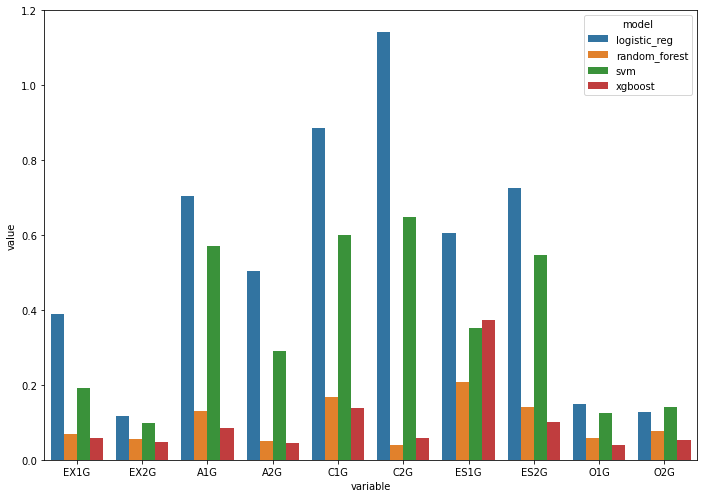

In [285]:
clf = LogisticRegression(solver="lbfgs", penalty="none")
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_lr = get_feature_importance(output)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_rf = get_feature_importance(output)

clf = svm.SVC(kernel="linear")
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_svm = get_feature_importance(output)

clf = XGBClassifier(random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_xgboost = get_feature_importance(output)

feature_importance_lr['model'] ="logistic_reg"
feature_importance_rf['model'] ="random_forest"
feature_importance_svm['model'] ="svm"
feature_importance_xgboost['model'] ="xgboost"

comparison_df = pd.DataFrame.from_dict([feature_importance_lr, 
                        feature_importance_rf, 
                        feature_importance_svm,
                        feature_importance_xgboost])

comparison_df = comparison_df.melt(id_vars=["model"])

sns.barplot(data=comparison_df, x="variable", y="value", hue="model")

### Logistic Regression

Cross-Validated F1-Score: 0.8098047607227533


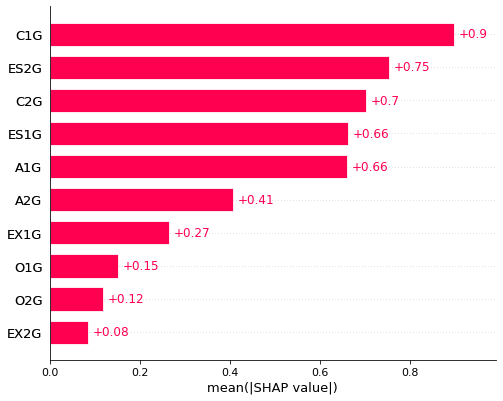

In [286]:
clf = LogisticRegression(solver="lbfgs", penalty="none")
shap_values_lr, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_lr)

### Random Forest

Cross-Validated F1-Score: 0.8264135923136632


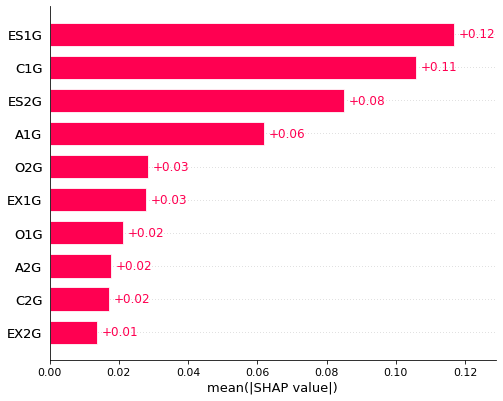

In [280]:
clf = RandomForestClassifier(random_state=42)
shap_values_rf, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_rf[:,:,1])

### SVM

Cross-Validated F1-Score: 0.8193417996883913


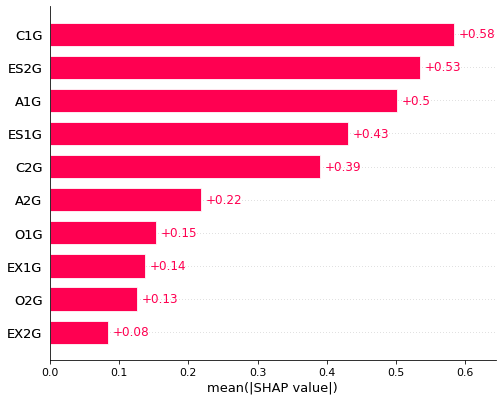

In [235]:
clf = svm.SVC(kernel="linear")
shap_values_svm, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_svm)

### XGBoost

Cross-Validated F1-Score: 0.8115609110462632


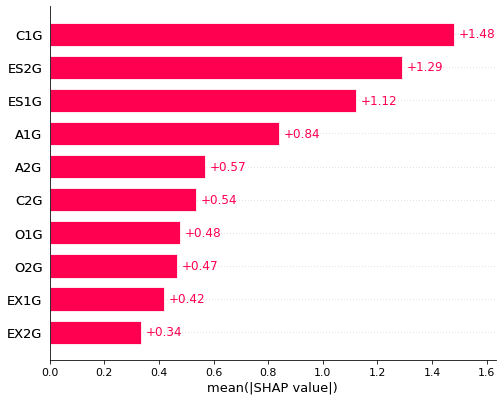

In [236]:
clf = XGBClassifier(random_state=42)
shap_values_xgboost, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_xgboost)

### Comparison Between Models

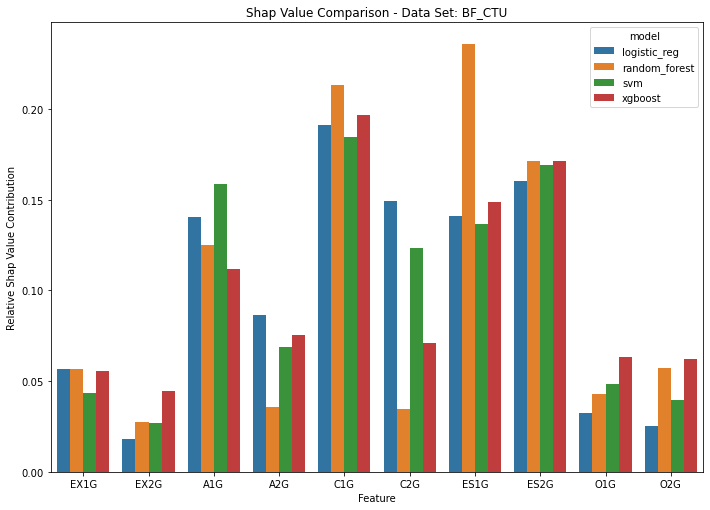

In [287]:
df = BF_CTU_df

def compute_relative_shap_values(shap_values, col_names):    
    mean_shap_values = np.mean(np.abs(shap_values.values), axis=0)
    relative_shap_values = mean_shap_values / np.sum(mean_shap_values)
    relative_shap_values = dict(zip(col_names, relative_shap_values))
    return relative_shap_values

rel_shap_values_lr = compute_relative_shap_values(shap_values_lr, df.columns)
rel_shap_values_rf = compute_relative_shap_values(shap_values_rf[:,:,1], df.columns)
rel_shap_values_svm = compute_relative_shap_values(shap_values_svm, df.columns)
rel_shap_values_xgboost = compute_relative_shap_values(shap_values_xgboost, df.columns)

rel_shap_values_lr['model'] ="logistic_reg"
rel_shap_values_rf['model'] ="random_forest"
rel_shap_values_svm['model'] ="svm"
rel_shap_values_xgboost['model'] ="xgboost"

comparison_df = pd.DataFrame.from_dict([rel_shap_values_lr, 
                        rel_shap_values_rf, 
                        rel_shap_values_svm,
                        rel_shap_values_xgboost])

comparison_df = comparison_df.melt(id_vars=["model"])

ax = sns.barplot(data=comparison_df, x="variable", y="value", hue="model")
ax.set_title('Shap Value Comparison - Data Set: BF_CTU')
ax.set_ylabel('Relative Shap Value Contribution')
ax.set_xlabel('Feature')
plt.show()

## Feature Selection Methods

### PCA

### Chi-Square

### Autoencoder Thing

### Sparce-PCA

### Etc

Feature importance scores can be fed to a wrapper model, such as the "SelectFromModel" class, to perform feature selection.

Way to calculate features importances:
- Coefficient statistic between each features